# Modelo de análisis de CVs
El presente archivo presentará la posibilidad de generar con base en 300 HVs tanto rechazadas como avanzadas, un modelo que nos permita identificar las carácterísticas predominantes de una HV que hace que avance o no durante el proceso.


### Importar librerías necesarias

In [28]:
from IPython.display import Image, display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

### Cargar datos

In [29]:
data = pd.read_csv("baseCVs.csv")

### Descriptivo de la base

In [30]:
def describir_base_datos(data):

    print("Información general de la base de datos:\n")
    print(data.info())

    print("\nEstadísticas descriptivas de las variables numéricas:\n")
    print(data.describe())

    print("\nValores únicos de las variables categóricas:\n")
    for columna in data.select_dtypes(include=['object', 'category']).columns:
        print(f"\nColumna: {columna}")
        print(data[columna].unique())

    print("\nFrecuencia de la variable 'Passed':\n")
    print(data['Passed'].value_counts()) # Calcula y muestra las frecuencias de 'target'

    print("\nValores faltantes por columna:\n")
    print(data.isnull().sum())

describir_base_datos(data)

Información general de la base de datos:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509 entries, 0 to 508
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   Total_Word_Count                 509 non-null    int64
 1   Has_Photo                        509 non-null    int64
 2   Has_Colors                       509 non-null    int64
 3   Pages                            509 non-null    int64
 4   Keyword_Count                    509 non-null    int64
 5   Education_Exists                 509 non-null    int64
 6   Education_Word_Count             509 non-null    int64
 7   Work_Experience_Exists           509 non-null    int64
 8   Work_Experience_Word_Count       509 non-null    int64
 9   Skills_Exists                    509 non-null    int64
 10  Skills_Word_Count                509 non-null    int64
 11  Certifications_Exists            509 non-null    int64
 12  Certific

### División de la base en Train y Test

In [31]:
x_train, x_test, y_train, y = train_test_split(data, data['Passed'], test_size=0.3, random_state=69)

print("Forma de x_train:", x_train.shape)
print("Forma de x_test:", x_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y:", y.shape)

Forma de x_train: (356, 22)
Forma de x_test: (153, 22)
Forma de y_train: (356,)
Forma de y: (153,)


# Validamos si necesitamos escalado
Inicialmente al usar un modelo basado en árboles no necesitamos escalado.



# Análisis con Random Forest para conseguir prestaciones top baseline

Vamos a realizar una estimación de las prestaciones más precisas que podríamos alcanzar al modelar esta base de datos con aprendizaje automático.

Para ello emplearemos *Random Forest* buscando valores para el número de hojas y el tamaño del bosque.

In [32]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score

def analizar_random_forest_optimo(data, target_col='Passed', test_size=0.3, random_state=42, cv_splits=3):

    x = data.drop(columns=[target_col])
    y = data[target_col]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state, stratify=y)

    rf = RandomForestClassifier(random_state=random_state)

    param_grid = {
        'n_estimators': [100, 300, 500, 700, 900],
        'max_depth': [5, 10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], refit='accuracy', n_jobs=-1, verbose=0)
    grid_search.fit(x_train, y_train)

    best_rf = grid_search.best_estimator_

    y_pred = best_rf.predict(x_test)
    y_pred_proba = best_rf.predict_proba(x_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print("Mejores hiperparámetros:", grid_search.best_params_)
    print("Precisión:", accuracy)
    print("Precisión:", precision)
    print("Recuperación:", recall)
    print("Puntuación F1:", f1)
    print("AUC ROC:", roc_auc)
    print("Reporte de clasificación:\n", classification_report(y_test, y_pred))

    #Extra#
    feature_importances = pd.Series(best_rf.feature_importances_, index=x_train.columns).sort_values(ascending=False)
    print("\nRanking de variables por importancia de Random Forest:")
    print(feature_importances)

    return grid_search.best_params_, (accuracy, precision, recall, f1, roc_auc), feature_importances


In [33]:
mejores_params, metrics, ranking_variables = analizar_random_forest_optimo(data)

Mejores hiperparámetros: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 700}
Precisión: 0.6013071895424836
Precisión: 0.5
Recuperación: 0.04918032786885246
Puntuación F1: 0.08955223880597014
AUC ROC: 0.49670349251603707
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.61      0.97      0.74        92
           1       0.50      0.05      0.09        61

    accuracy                           0.60       153
   macro avg       0.55      0.51      0.42       153
weighted avg       0.56      0.60      0.48       153


Ranking de variables por importancia de Random Forest:
Skills_Word_Count                  0.133500
Total_Word_Count                   0.131387
Education_Word_Count               0.127099
projects_Word_Count                0.100601
Work_Experience_Word_Count         0.099495
Professional_Profile_Word_Count    0.074764
Keyword_Count                      0.067257
Pages                       

In [34]:
from sklearn.feature_selection import mutual_info_classif

def analizar_relevancia_informacion_mutua(dta_ohe, target_col='Passed', test_size=0.3, random_state=42):

    X = dta_ohe.drop(columns=[target_col])
    y = dta_ohe[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    f_test = mutual_info_classif(x_train, y_train, random_state=random_state)
    feature_scores = pd.Series(f_test, index=x_train.columns).sort_values(ascending=False)

    print("Ranking de variables por información mutua:")
    print(feature_scores)

    plt.figure(figsize=(10, len(feature_scores) * 0.3))
    sns.barplot(x=feature_scores, y=feature_scores.index)
    plt.title("Información mutua por variable")
    plt.xlabel("Puntuación de información mutua")
    plt.ylabel("Variable")
    plt.show()

    return feature_scores

Ranking de variables por información mutua:
Skills_Word_Count                  0.061726
volunteer_work_Exists              0.030366
Has_Photo                          0.021398
Certifications_Exists              0.017546
Education_Word_Count               0.013709
Work_Experience_Exists             0.013696
Keyword_Count                      0.006334
Achievements_Exists                0.003786
Has_Colors                         0.001420
Achievements_Word_Count            0.000000
projects_Word_Count                0.000000
Projects_Exists                    0.000000
Professional_Profile_Word_Count    0.000000
Professional_Profile_Exists        0.000000
Total_Word_Count                   0.000000
Certifications_Word_Count          0.000000
Skills_Exists                      0.000000
Work_Experience_Word_Count         0.000000
Education_Exists                   0.000000
Pages                              0.000000
volunteer_work_Word_Count          0.000000
dtype: float64


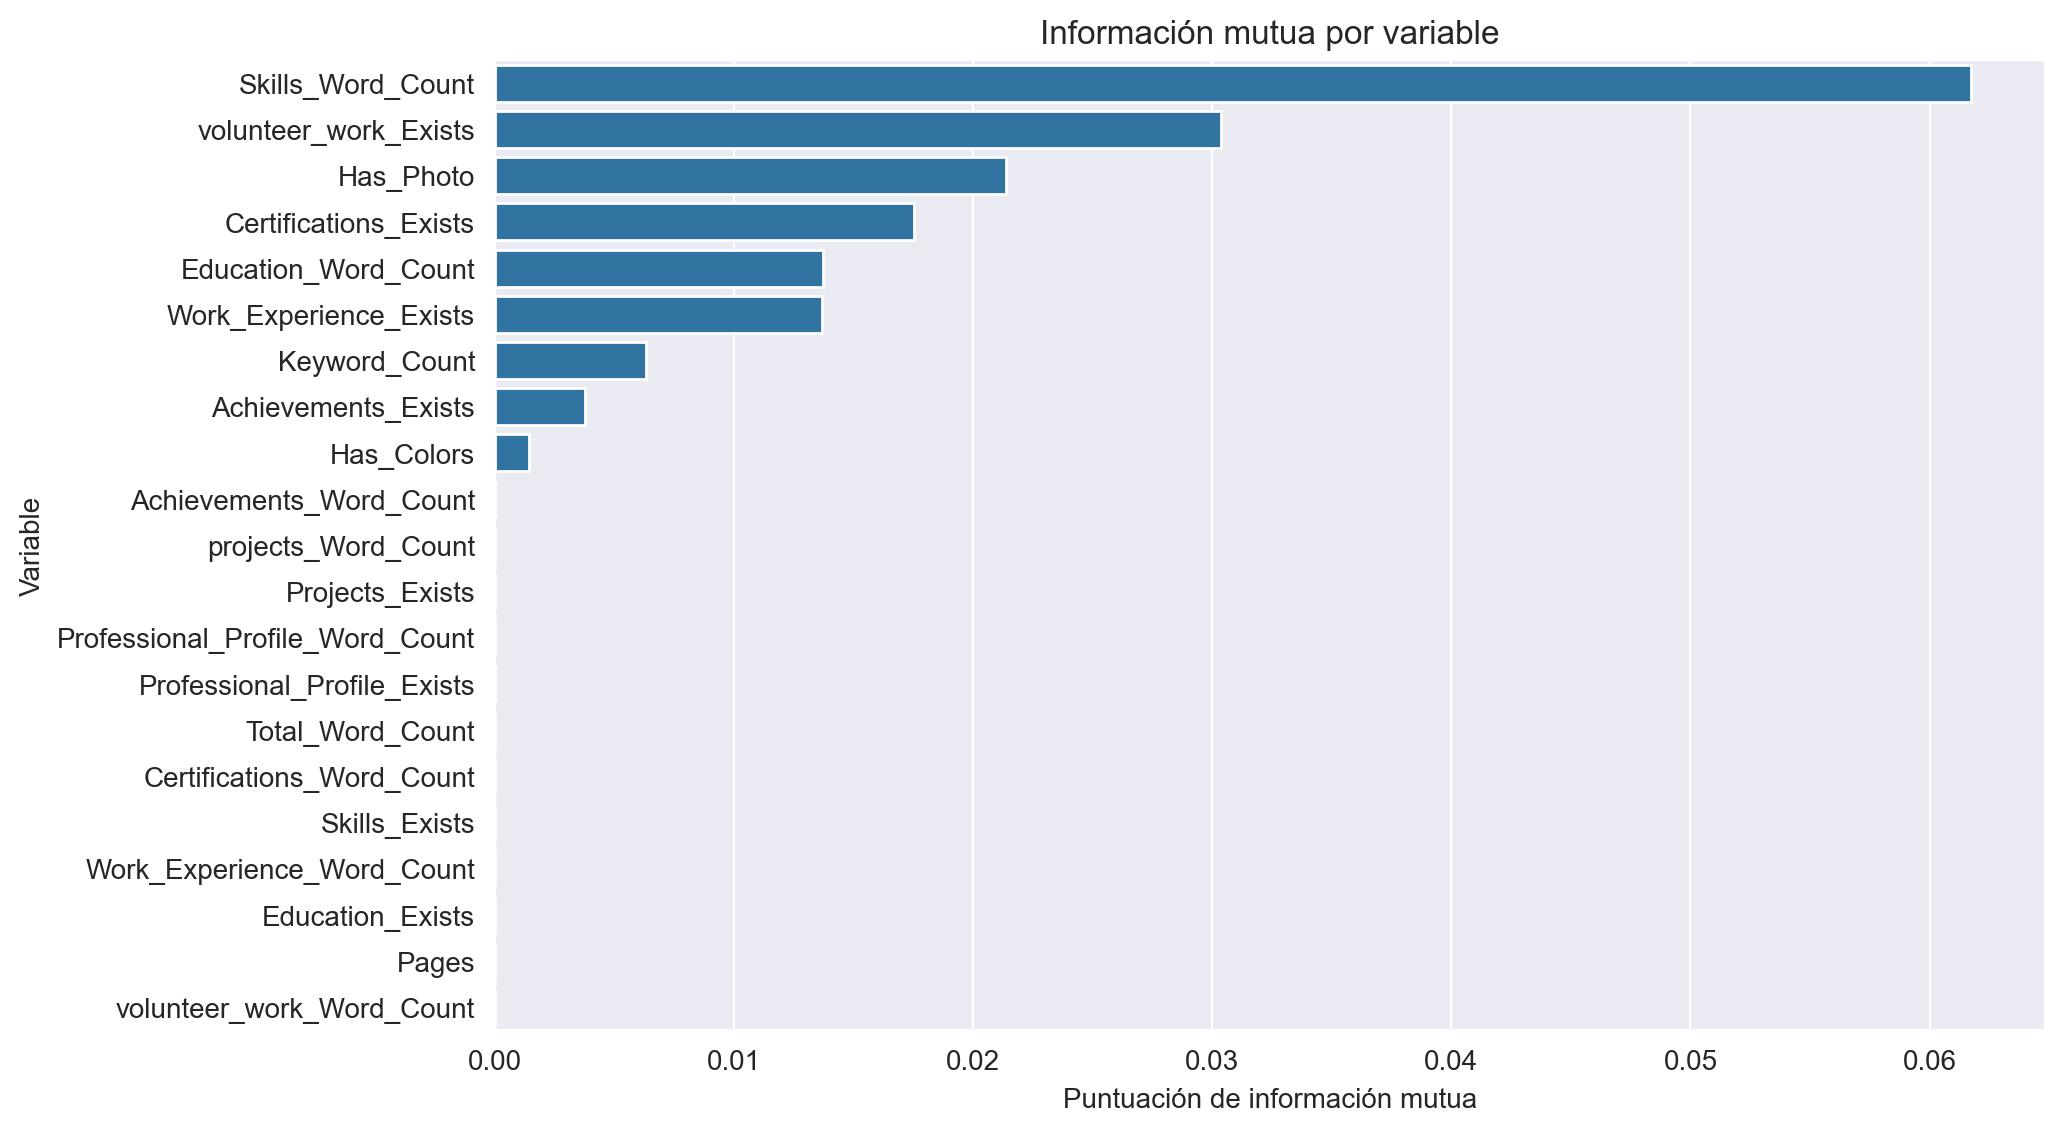

In [35]:
feature_scores = analizar_relevancia_informacion_mutua(data)

## Selección de variables con información mutua y validación cruzada


In [36]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score

def seleccionar_variables_knn_varias_k(data, target_col='Passed', test_size=0.3, random_state=69, cv_splits=3, k_values=[10, 20, 21]):

    X = data.drop(columns=[target_col])
    y = data[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    resultados = {}
    for k in k_values:
        pipeline = Pipeline([
            ('select', SelectKBest(score_func=mutual_info_classif, k=k)),
            ('scaler', StandardScaler()),
            ('knn', KNeighborsClassifier())
        ])

        param_grid = {
            'knn__n_neighbors': [3, 5, 7, 10, 15],
            'knn__weights': ['uniform', 'distance']
        }

        cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], refit='accuracy', n_jobs=-1, verbose=0)
        grid_search.fit(x_train, y_train)

        best_params = grid_search.best_params_
        best_knn = grid_search.best_estimator_

        y_pred = best_knn.predict(x_test)
        y_pred_proba = best_knn.predict_proba(x_test)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        # Obtener las variables seleccionadas
        selected_features = x_train.columns[grid_search.best_estimator_.named_steps['select'].get_support()]
        riesgo_entrenamiento = grid_search.score(x_train, y_train)
        riesgo_test = grid_search.score(x_test, y_test)

        resultados[k] = {
            'best_params': best_params,
            'metrics': (accuracy, precision, recall, f1, roc_auc),
            'model': best_knn,
            'selected_features': selected_features  # Agregar las variables seleccionadas
        }

        print(f"Resultados para k={k}:")
        print("Mejores hiperparámetros:", best_params)
        print("Precisión:", accuracy)
        print("Precisión:", precision)
        print("Recuperación:", recall)
        print("Puntuación F1:", f1)
        print("AUC ROC:", roc_auc)
        print("Reporte de clasificación:\n", classification_report(y_test, y_pred))
        print("Acierto en el conjunto de entrenamiento: {0:.2f}(%)".format(100.*riesgo_entrenamiento))
        print("Acierto en el conjunto de test: {0:.2f}(%)".format(100.*riesgo_test))
        print("Variables seleccionadas:", selected_features)  # Imprimir las variables seleccionadas

    return resultados

In [37]:
resultados_knn = seleccionar_variables_knn_varias_k(data)

Resultados para k=10:
Mejores hiperparámetros: {'knn__n_neighbors': 10, 'knn__weights': 'uniform'}
Precisión: 0.5490196078431373
Precisión: 0.3333333333333333
Recuperación: 0.13114754098360656
Puntuación F1: 0.18823529411764706
AUC ROC: 0.5221846044191019
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.59      0.83      0.69        92
           1       0.33      0.13      0.19        61

    accuracy                           0.55       153
   macro avg       0.46      0.48      0.44       153
weighted avg       0.49      0.55      0.49       153

Acierto en el conjunto de entrenamiento: 63.76(%)
Acierto en el conjunto de test: 54.90(%)
Variables seleccionadas: Index(['Pages', 'Education_Exists', 'Education_Word_Count',
       'Work_Experience_Word_Count', 'Achievements_Word_Count',
       'Professional_Profile_Exists', 'Projects_Exists', 'projects_Word_Count',
       'volunteer_work_Exists', 'volunteer_work_Word_Count'],
      dt

## Agregar variables al modelo


In [38]:
def agregar_variables_recursivamente(data, target_col='Passed', test_size=0.3, random_state=42):
    """
    Agrega variables al modelo recursivamente y grafica la precisión.

    Args:
        dta_ohe (pd.DataFrame): DataFrame con variables codificadas one-hot.
        target_col (str): Nombre de la columna objetivo.
        test_size (float): Tamaño del conjunto de prueba.
        random_state (int): Semilla para reproducibilidad.

    Returns:
        tuple: Orden de variables añadidas y lista de precisiones en prueba.
    """
    X = data.drop(columns=[target_col])
    y = data[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    orden_variables = []
    precisiones_test = []

    variables_actuales = []
    for _ in range(X.shape[1]):
        mejores_variables = []
        mejor_precision = 0

        variables_restantes = [col for col in X.columns if col not in variables_actuales]
        for variable in variables_restantes:
            variables_prueba = variables_actuales + [variable]
            model = RandomForestClassifier(random_state=random_state)
            model.fit(x_train[variables_prueba], y_train)
            y_pred = model.predict(x_test[variables_prueba])
            precision = accuracy_score(y_test, y_pred)

            if precision > mejor_precision:
                mejor_precision = precision
                mejores_variables = variables_prueba + []

        variables_actuales = mejores_variables
        orden_variables.append(variables_actuales[-1])
        precisiones_test.append(mejor_precision)

    print("Orden de variables añadidas:", orden_variables)

    plt.plot(range(1, len(precisiones_test) + 1), precisiones_test)
    plt.xlabel("Número de variables")
    plt.ylabel("Precisión en prueba")
    plt.title("Precisión vs. Número de variables añadidas")
    plt.show()

    return orden_variables, precisiones_test

Orden de variables añadidas: ['Education_Word_Count', 'Education_Exists', 'Professional_Profile_Word_Count', 'volunteer_work_Exists', 'Skills_Exists', 'Skills_Word_Count', 'Work_Experience_Exists', 'Achievements_Exists', 'Has_Colors', 'Professional_Profile_Exists', 'Has_Photo', 'Pages', 'projects_Word_Count', 'Keyword_Count', 'volunteer_work_Word_Count', 'Work_Experience_Word_Count', 'Achievements_Word_Count', 'Projects_Exists', 'Total_Word_Count', 'Certifications_Word_Count', 'Certifications_Exists']


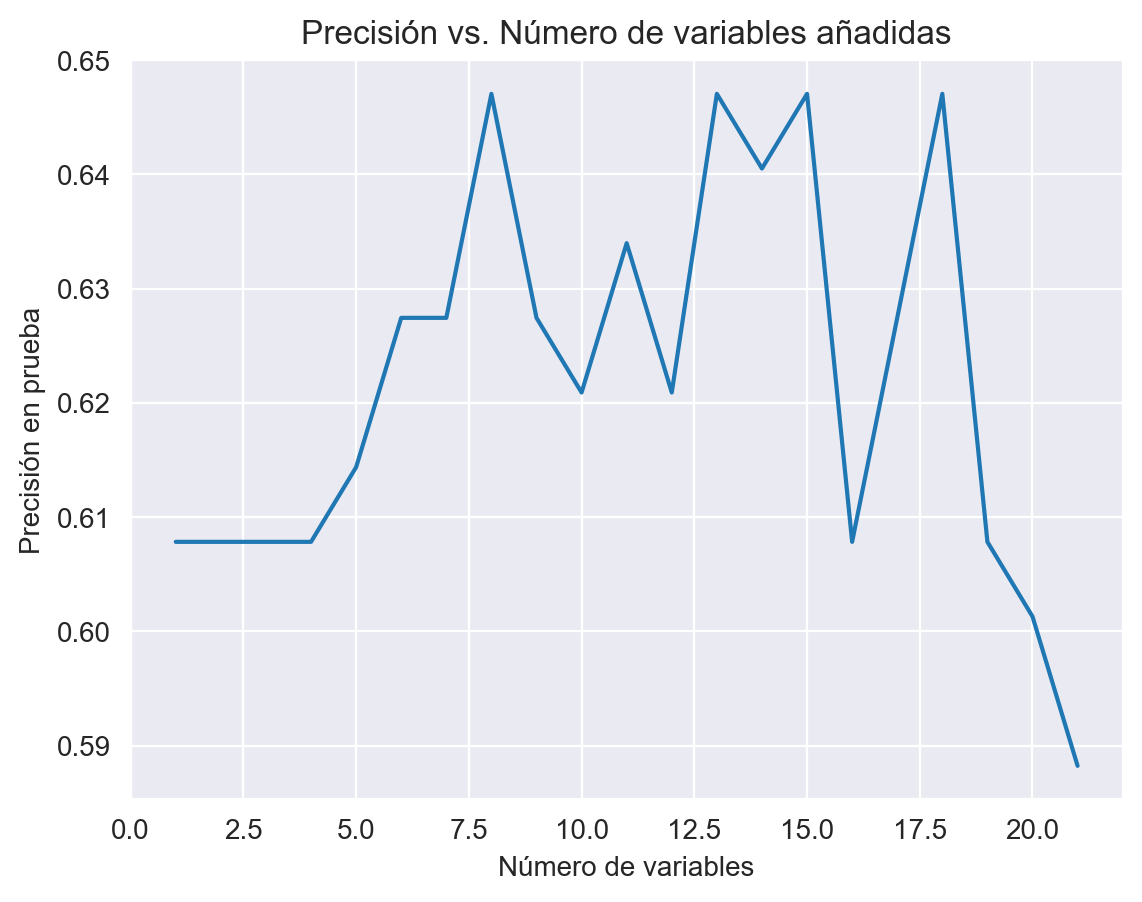

In [39]:
orden_vars, precisiones = agregar_variables_recursivamente(data)


Eliminar Variables del modelo

In [40]:
def eliminar_variables_recursivamente(dta_ohe, target_col='Passed', test_size=0.3, random_state=69):

    X = dta_ohe.drop(columns=[target_col])
    y = dta_ohe[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    orden_variables = []
    precisiones_test = []

    variables_actuales = list(X.columns)
    while len(variables_actuales) > 1:
        peor_variable = None
        mejor_precision = 0

        for variable in variables_actuales:
            variables_prueba = [v for v in variables_actuales if v != variable]
            model = RandomForestClassifier(random_state=random_state)
            model.fit(x_train[variables_prueba], y_train)
            y_pred = model.predict(x_test[variables_prueba])
            precision = accuracy_score(y_test, y_pred)

            if precision > mejor_precision:
                mejor_precision = precision
                peor_variable = variable

        variables_actuales.remove(peor_variable)
        orden_variables.append(peor_variable)
        precisiones_test.append(mejor_precision)

    print("Orden de variables eliminadas:", orden_variables)

    plt.plot(range(len(precisiones_test), 0, -1), precisiones_test)
    plt.xlabel("Número de variables")
    plt.ylabel("Precisión en prueba")
    plt.title("Precisión vs. Número de variables eliminadas")
    plt.show()

    return orden_variables, precisiones_test

Orden de variables eliminadas: ['Education_Word_Count', 'Total_Word_Count', 'Keyword_Count', 'Education_Exists', 'volunteer_work_Word_Count', 'volunteer_work_Exists', 'Certifications_Exists', 'projects_Word_Count', 'Achievements_Word_Count', 'Professional_Profile_Exists', 'Achievements_Exists', 'Work_Experience_Exists', 'Has_Colors', 'Projects_Exists', 'Skills_Exists', 'Pages', 'Work_Experience_Word_Count', 'Professional_Profile_Word_Count', 'Skills_Word_Count', 'Certifications_Word_Count']


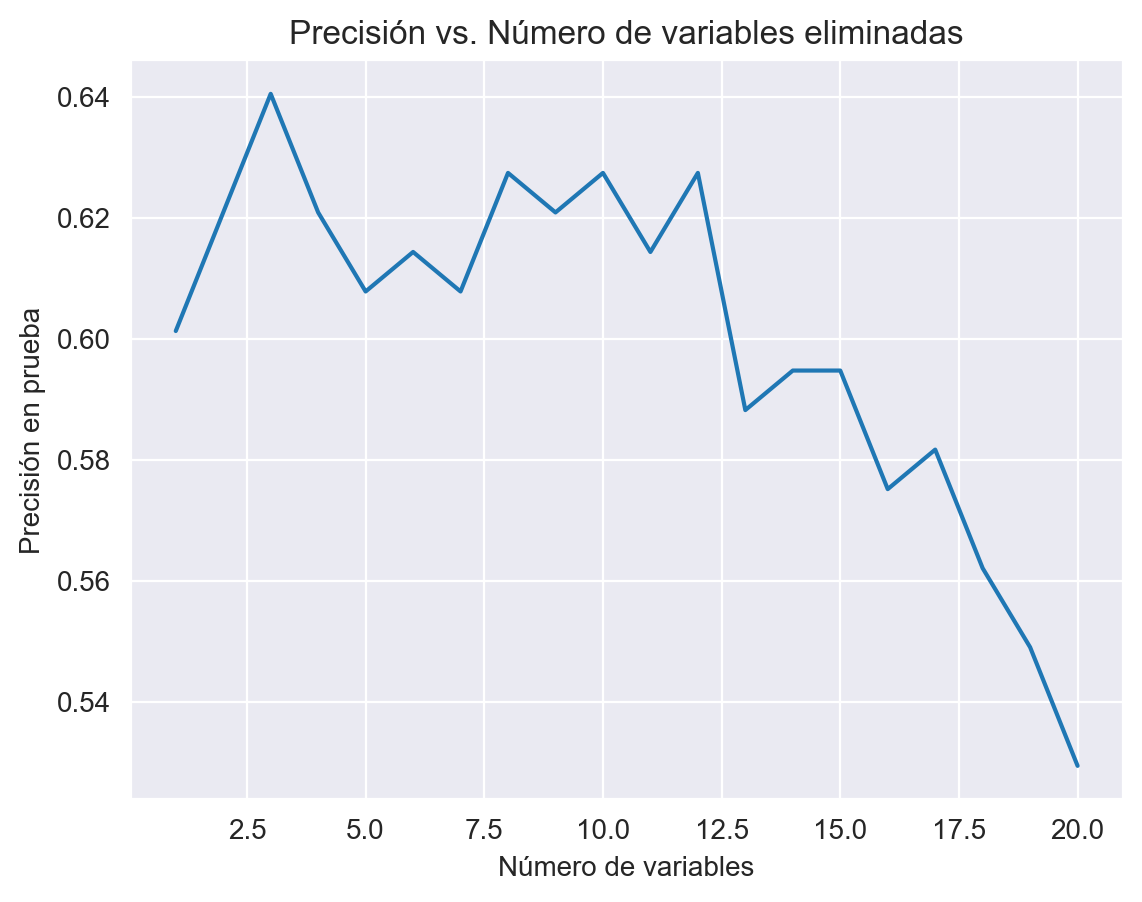

In [41]:
orden_vars, precisiones = eliminar_variables_recursivamente(data)

## Ranking de variables

In [42]:
def obtener_importancia_rf(dta_ohe, target_col='Passed', test_size=0.3, random_state=69):

    X = data.drop(columns=[target_col])
    y = data[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    model = RandomForestClassifier(random_state=random_state)
    model.fit(x_train, y_train)

    feature_importances = pd.Series(model.feature_importances_, index=x_train.columns).sort_values(ascending=False)

    print("Ranking de variables por importancia de Random Forest:")
    print(feature_importances)

    plt.figure(figsize=(10, len(feature_importances) * 0.3))
    sns.barplot(x=feature_importances, y=feature_importances.index)
    plt.title("Importancia de variables de Random Forest")
    plt.xlabel("Importancia")
    plt.ylabel("Variable")
    plt.show()

    return feature_importances


Ranking de variables por importancia de Random Forest:
Total_Word_Count                   0.153059
Education_Word_Count               0.119584
Skills_Word_Count                  0.100433
Keyword_Count                      0.094810
projects_Word_Count                0.091845
Professional_Profile_Word_Count    0.089516
Pages                              0.070792
Work_Experience_Word_Count         0.068574
Achievements_Word_Count            0.028127
Certifications_Word_Count          0.027758
Has_Photo                          0.026012
Professional_Profile_Exists        0.019960
Work_Experience_Exists             0.019053
Projects_Exists                    0.017987
Skills_Exists                      0.016798
Education_Exists                   0.013291
Certifications_Exists              0.011180
Achievements_Exists                0.008956
volunteer_work_Word_Count          0.008821
volunteer_work_Exists              0.008803
Has_Colors                         0.004643
dtype: float64


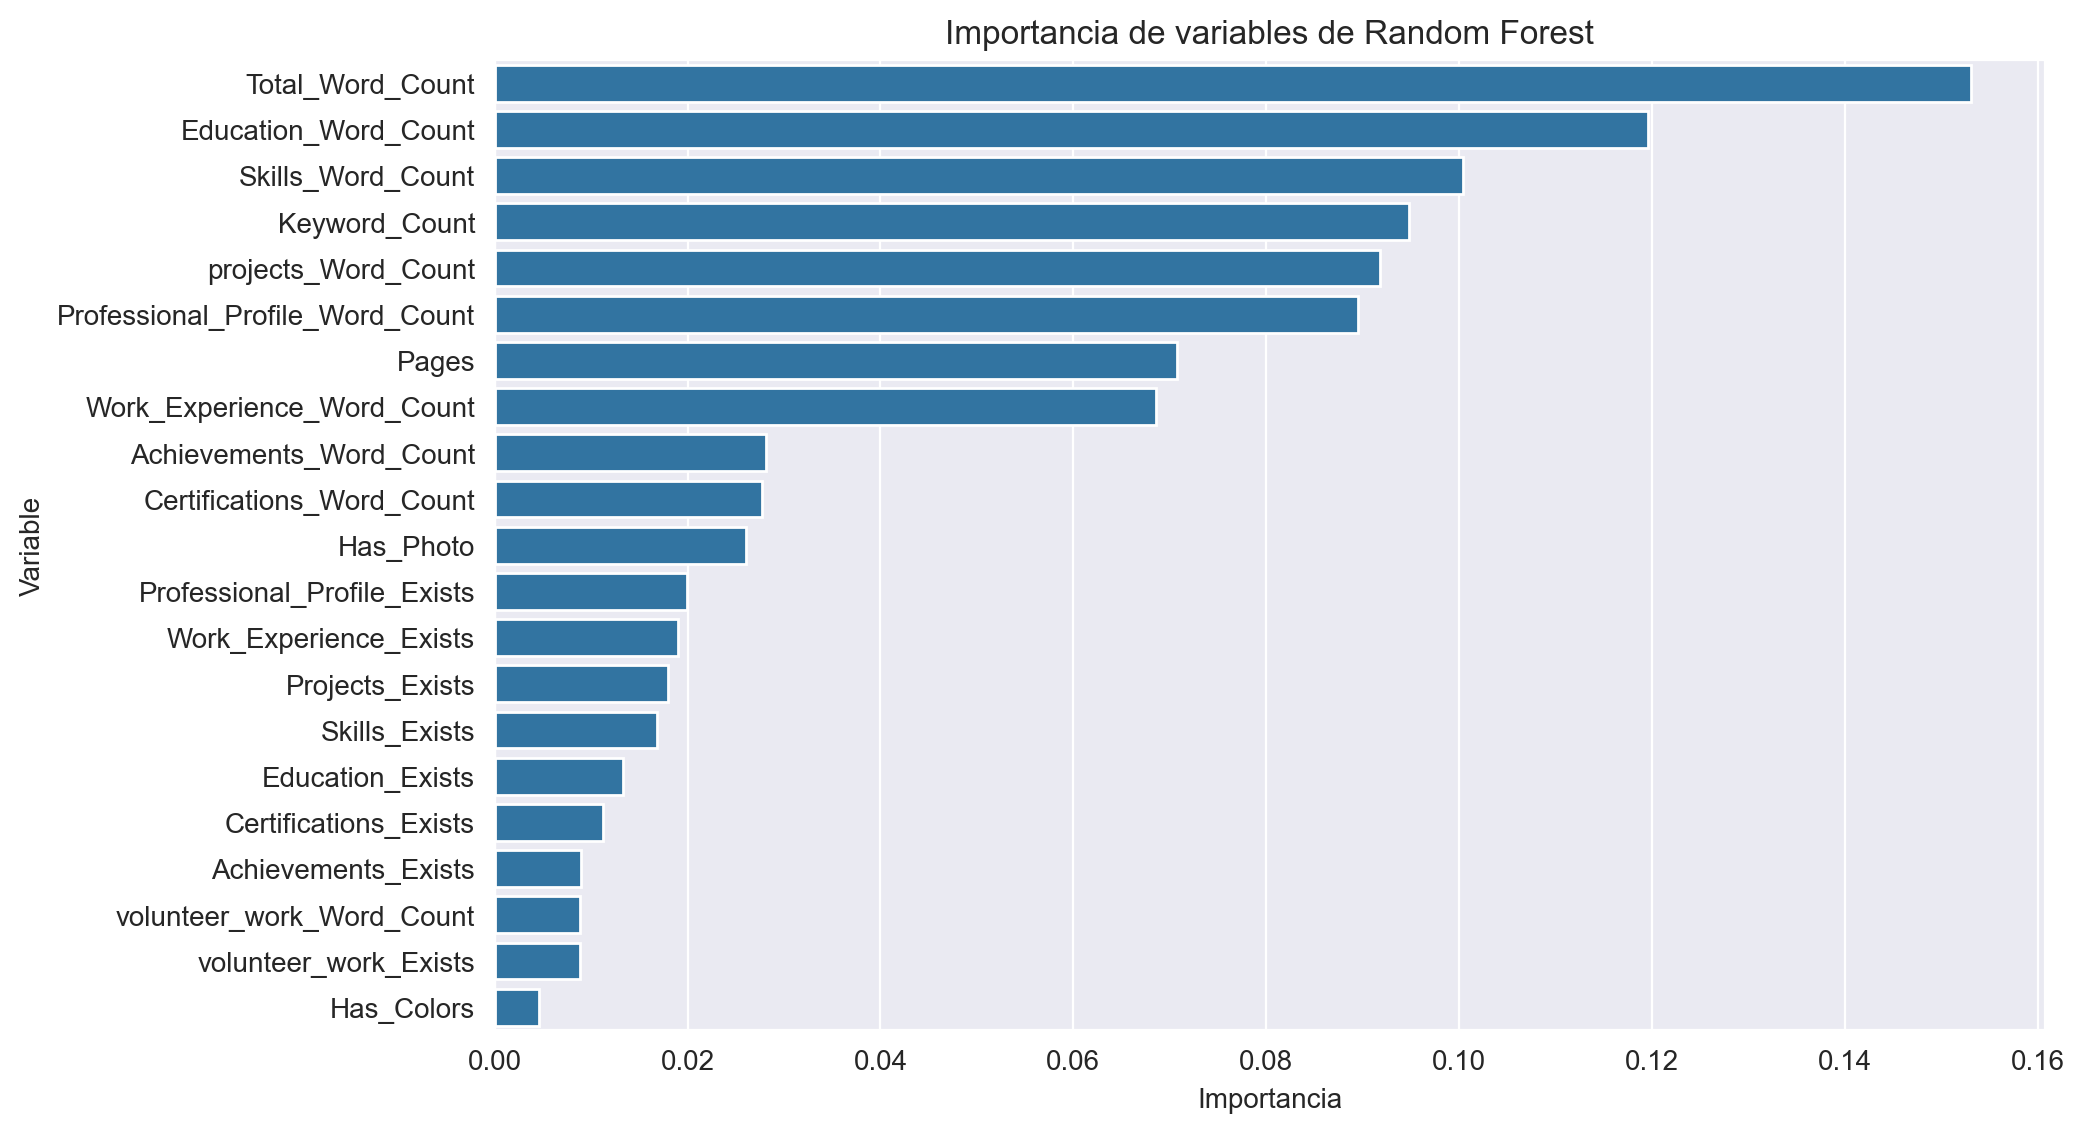

In [43]:
importancia_rf = obtener_importancia_rf(data)

# prueba con nuevo script ajustando muestra


In [44]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# 📌 Step 1: Load the dataset
df = pd.read_csv("baseCVs.csv")

# 📌 Step 2: Define features & target variable
X = df.drop(columns=["Passed"])  # Features
y = df["Passed"]  # Target (0 = rejected, 1 = selected)

# 📌 Step 3: Remove low-importance features
low_importance_features = ["Has_Colors", "volunteer_work_Exists", "volunteer_work_Word_Count", "Has_Photo"]
X = X.drop(columns=low_importance_features)

# 📌 Step 4: Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 📌 Step 5: Handle Class Imbalance
# Choose between SMOTE (Oversampling) or Undersampling
use_smote = True  # Change to False to use undersampling instead

if use_smote:
    smote = SMOTE(sampling_strategy="auto", random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
else:
    undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
    X_train, y_train = undersample.fit_resample(X_train, y_train)

# 📌 Step 6: Hyperparameter tuning with GridSearchCV
param_grid = {
    "n_estimators": [500, 700, 1000],  # Number of trees
    "max_depth": [5, 10, 15],  # Depth of trees
    "min_samples_split": [2, 5, 10],  # Min samples to split a node
    "min_samples_leaf": [1, 3, 5],  # Min samples per leaf
}

rf = RandomForestClassifier(random_state=69)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="f1", n_jobs=-1)
grid_search.fit(X_train, y_train)

# 📌 Step 7: Train the best model
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# 📌 Step 8: Evaluate the model
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# 📌 Step 9: Print Metrics
print("🔹 Best Hyperparameters:", grid_search.best_params_)
print("🔹 AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))

# 📌 Step 10: Cross-Validation for Stability
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring="f1")
print("\n🔹 Cross-Validation F1 Score:", np.mean(cv_scores))

# 📌 Step 11: Feature Importance Ranking
feature_importances = pd.Series(best_rf.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)
print("\n🔹 Feature Importance:\n", feature_importances)


🔹 Best Hyperparameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 700}
🔹 AUC-ROC Score: 0.45927419354838717

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.63      0.61        62
           1       0.36      0.33      0.34        40

    accuracy                           0.51       102
   macro avg       0.48      0.48      0.48       102
weighted avg       0.50      0.51      0.50       102


🔹 Cross-Validation F1 Score: 0.6017142490536986

🔹 Feature Importance:
 Total_Word_Count                   0.158374
Education_Word_Count               0.119978
Skills_Word_Count                  0.119453
projects_Word_Count                0.109901
Work_Experience_Word_Count         0.105209
Professional_Profile_Word_Count    0.082058
Keyword_Count                      0.073703
Pages                              0.060564
Certifications_Word_Count          0.032446
Achievements_Word_Count       

### El modelo no funcionó bien con random forest, necesita ajuste.

Intentaremos con xGBoost

In [45]:
import xgboost as xgb
from imblearn.combine import SMOTEENN

# Remove non-numeric columns
if "CV_Name" in df.columns:
    df = df.drop(columns=["CV_Name"])

if "CV_Type" in df.columns:
    df = df.drop(columns=["CV_Type"])

# 📌 Feature Selection: Remove low-impact features
drop_columns = ["Has_Colors", "volunteer_work_Exists", "volunteer_work_Word_Count"]
X = df.drop(columns=["Passed"] + drop_columns)
y = df["Passed"]

# 📌 Feature Engineering: Add new feature
X["Relevant_Sections_Count"] = (
    X["Education_Exists"] + X["Work_Experience_Exists"] + X["Skills_Exists"]
)

# 📌 Convert categorical booleans to numeric (0/1)
boolean_columns = ["Education_Exists", "Skills_Exists", "Certifications_Exists"]
for col in boolean_columns:
    if col in X.columns:
        X[col] = X[col].astype(int)

# 📌 Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 📌 Apply SMOTEENN to balance classes
smoteenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)

# 📌 Train Optimized XGBoost Model
xgb_model = xgb.XGBClassifier(
    n_estimators=700,  # More trees for stability
    max_depth=4,  # Reduce depth to prevent overfitting
    learning_rate=0.05,  # Lower learning rate improves generalization
    subsample=0.6,  # Prevent overfitting
    colsample_bytree=0.8,  # Keep feature diversity
    min_child_weight=3,  # Prevents small splits
    scale_pos_weight=4,  # Adjust class balance
    random_state=42
)

xgb_model.fit(X_train_resampled, y_train_resampled)

# 📌 Make predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# 📌 Evaluate model
print("\n🔹 AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))

# 📌 Cross-validation for stability
cv_scores = cross_val_score(xgb_model, X_train_resampled, y_train_resampled, cv=5, scoring="f1")
print("\n🔹 Cross-Validation F1 Score:", np.mean(cv_scores))

# 📌 Feature Importance
feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\n🔹 Feature Importance:\n", feature_importances)


🔹 AUC-ROC Score: 0.5241935483870968

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.45      0.53        62
           1       0.41      0.60      0.49        40

    accuracy                           0.51       102
   macro avg       0.53      0.53      0.51       102
weighted avg       0.55      0.51      0.51       102


🔹 Cross-Validation F1 Score: 0.7976731601731601

🔹 Feature Importance:
 projects_Word_Count                0.097469
Achievements_Exists                0.085989
Projects_Exists                    0.082518
Professional_Profile_Exists        0.079621
Total_Word_Count                   0.071781
Work_Experience_Word_Count         0.069670
Keyword_Count                      0.062917
Work_Experience_Exists             0.060746
Relevant_Sections_Count            0.060150
Skills_Word_Count                  0.058868
Pages                              0.058109
Has_Photo                          0.056915
Educatio